<a href="https://colab.research.google.com/github/ahmadpnb/combinationforecast/blob/main/Anis_VECM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.7 MB/s eta 0:00:00


In [2]:
#packages needed for this script

import pandas as pd #package for data handling
import numpy as np #package for default arithmetic
import seaborn as sns #package for plotting graph
import matplotlib.pyplot as plt #package for plotting graph
import statsmodels.api as sm #package for models and other statistical test
from statsmodels.tsa.api import VAR #package for VAR model
from statsmodels.tsa.vector_ar.vecm import VECM #package for VECM model
from statsmodels.tsa.vector_ar.vecm import select_coint_rank #package for Johansen cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen #package for Johansen cointegration test
from statsmodels.tsa.vector_ar.vecm import select_order #package for selecting optimal lag length
from statsmodels.tsa.ar_model import ar_select_order #package to select lag order
from statsmodels.tsa.stattools import adfuller #package for ADF test for stationarity
from arch.unitroot import PhillipsPerron #package for Phillips Perron test for stationarity
from statsmodels.tsa.stattools import kpss #package for KPSS test for stationarity
from statsmodels.stats.diagnostic import het_breuschpagan #package for Breusch Pagan test for heteroscedasticity
from statsmodels.tsa.stattools import grangercausalitytests #package for granger causality tests
from sklearn.model_selection import train_test_split #package for train test split
from statsmodels.tools.eval_measures import rmse, aic #package for accuracy test
from statsmodels.tsa.arima.model import ARIMA #package for ARIMA
import statistics as st

In [3]:
# Functions for EDA

def eda(df):
  print(df.info())
  print()
  print()
  display(df.head(10), df.tail(10))
  print()
  print()
  print('Data summary statistics')
  display(df.describe())
  print()
  print()
  df.select_dtypes(include = np.number).plot(subplots = True, sharex = True, figsize = (11.69,8.27), use_index = True, title = "Graphs of all variables", legend = True, xlabel = "Date")
  plt.show()
  print()
  print()
  pairplot = sns.pairplot(data = df.select_dtypes(include = np.number), kind = "reg", diag_kind = "hist", dropna = True)
  pairplot.fig.subplots_adjust(top = .95)
  pairplot.fig.suptitle("Variables distribution and two way relationships")
  plt.show()
  print()
  print()
  sns.heatmap(data = df.corr(numeric_only = True), cmap = "RdYlGn", center = 0, robust = True, square = True, annot = True, fmt = ".0%", linewidth = 0.5)
  plt.title("Correlation matrix between variables")
  plt.show()

In [4]:
# functions for transformation

# function to log selected columns
def transform_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].transform(np.log)

  return df


# function to difference selected columns
def transform_diff(df, second_diff = False):

  print(df.columns)
  input_string = input("Enter all columns' name to be diff separated by space: ")
  columns = input_string.split(" ")

  second_diff = int(input("1 if need second difference, 0 if do not need second difference: "))

  for i in columns:
    print("Column: " + i)
    df[i] = df[i].diff(int(input("Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  if second_diff == True:
      print(df.columns)
      input_string_2 = input("Enter all columns' name to be second differenced separated by space: ")
      columns_2 = input_string_2.split(" ")

      for i in columns_2:
        print("Column: " + i)
        df[i] = df[i].diff(int(input("Please enter the number of second difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  return df


# function to perform data transformation
def transform_data(df, to_log = False, to_diff = False):

  transform = df.copy()
  to_log = int(input("1 if need to log, 0 if no need to log: "))
  to_diff = int(input("1 if need to diff, 0 if no need to diff: "))

  if to_log == True and to_diff == False:
    transform_log(transform)

  elif to_log == False and to_diff == True:
    transform_diff(transform)

  elif to_log == True and to_diff == True:
    transform_log(transform)
    transform_diff(transform)

  return transform


# function to invert differenced columns
def invert_diff(original_df, differenced_df, second_diff = False):

    second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

    if second_diff == True:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo second differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        second_d = int(input("Please insert the number of difference for the second difference: "))
        diff = original_df[i].diff(first_d)
        first_invert = diff.shift(second_d) + differenced_df[i]
        second_invert = original_df[i].shift(first_d) + first_invert
        differenced_df[i] = second_invert

      print(original_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    elif second_diff == False:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo first differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    return differenced_df


# Function to invert log transformation
def invert_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be inverted its log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].apply(np.exp)

  return df


# Function to perform inverse transformation
def inverse_transformation(original_data, differenced_data, log = False, diff = False):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

In [5]:
# Functions for testing

# function for colour formatting for pvalue - hypothesis testing
def pvalue_formatting(col):
    if col.name == '10%':
        return ['background-color: green' if c < 0.1 else 'background-color: red' for c in col.values]
    if col.name == '5%':
        return ['background-color: green' if c < 0.05 else 'background-color: red' for c in col.values]
    if col.name == '1%':
        return ['background-color: green' if c < 0.01 else 'background-color: red' for c in col.values]

def pvalue_formatting2(col):
    if col.name == '10%':
        return ['background-color: red' if c < 0.1 else 'background-color: green' for c in col.values]
    if col.name == '5%':
        return ['background-color: red' if c < 0.05 else 'background-color: green' for c in col.values]
    if col.name == '1%':
        return ['background-color: red' if c < 0.01 else 'background-color: green' for c in col.values]


# function to perform ADF test
def adf_test(df):

  indicator = []
  pvalue = []

  for column in df:
    adf = adfuller(df[column], regression = 'ct')
    p_value = adf[1]
    indicator.append(column)
    pvalue.append(p_value)

  adf_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("ADF test for stationarity: H0 is time series is not stationary")
  display(adf_test)


# Function to perform Phillips Perron test
def pp_test(df):

  indicator = []
  pvalue = []

  for column in df:
    pp = PhillipsPerron(df[column])
    p_value = pp.pvalue
    indicator.append(column)
    pvalue.append(p_value)

  pp_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("PP test for stationarity: H0 is time series is not stationary")
  display(pp_test)


# Function to perform KPSS test
def kpss_test(df):

  indicator = []
  pvalue = []

  for column in df:
    kpss_test = kpss(df[column], regression = 'ct')
    p_value = kpss_test[1]
    indicator.append(column)
    pvalue.append(p_value)

  kpss_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print("KPSS test for stationarity: H0 is time series is stationary")
  display(kpss_test)


# Function to perform all stationarity test
def stationarity_test(df):

  print("Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise")
  print()
  adf_test(df)
  print()
  pp_test(df)
  print()
  kpss_test(df)


# Function to estimate ACF and PACF for autocorrelation
def acf_pacf_analysis(x, max_lags=12):
    acf_values = sm.tsa.acf(x)
    pacf_values = sm.tsa.pacf(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.suptitle("ACF and PACF graph for " + x.name)
    plt.show()


# Function to graph ACF and PACF
def acf_pacf_graph(df):
  for column in df:
    acf_pacf_analysis(df[column])

# Function for accuracy testing
def forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',input("Please put model name: ")," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


# Function for random walk accuracy testing
def rw_forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',"Random walk model"," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

def adjust(val, length= 6): return str(val).ljust(length)


# Function to find the optimal lag for VECM model

def vecm_optimal_lag(df):
  lags = 2
  if df.index.freq == 'm':
    lags = 12
    seasons = 12
  elif df.index.freq == 'q':
    lags = 4
    seasons = 4

  deterministic = input("n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): ")

  result = select_order(df, deterministic = deterministic, maxlags = lags, seasons = seasons)
  print()
  print()
  print(result.summary())
  print()
  print()
  lag = [result.aic, result.bic, result.fpe, result.hqic]
  if len(st.multimode(lag)) != 1:
    optimal_lag = result.aic
  elif len(st.multimode(lag)) == 1:
    optimal_lag = st.mode(lag)
  print("The optimal lag for the model is",optimal_lag)

  return optimal_lag


# Functio to test cointegraion rank

def cointegration_test(df):

  lag = int(input("Insert optimal lag number obtained from test: "))
  deterministic = int(input("-1 - no deterministic terms, 0 - constant term, 1 - linear trend "))
  print()
  print()
  trace_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "trace")
  print(trace_coint_rank_result.summary())
  print("Trace method cointegration test suggest a cointegration rank of",trace_coint_rank_result.rank)
  print()
  print()
  maxeig_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "maxeig")
  print(maxeig_coint_rank_result.summary())
  print("Maximum Eigenvalue method cointegration test suggest a cointegration rank of",maxeig_coint_rank_result.rank)
  rank = [trace_coint_rank_result.rank, maxeig_coint_rank_result.rank]
  if trace_coint_rank_result.rank != maxeig_coint_rank_result.rank:
    coint_rank = trace_coint_rank_result.rank
  else:
    coint_rank = st.mode(rank)

  return coint_rank

In [6]:
# Function to perform VECM model with automatice lag order selection

def vecm_model(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by comma: ").lower()
  variables_list  = variables_input.split(",")
  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = variables_list.copy()
  var_list.remove(main_endog)

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")

  if transformed_df.index.freq == 'm':
    seasons = 12
    lags = 12
  elif transformed_df.index.freq == 'q':
    seasons = 4
    lags = 4

  deterministic = input("Select your deterministic terms: n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept) ")
  optimal_lag = vecm_optimal_lag(transformed_df)
  coint_rank = cointegration_test(transformed_df)
  print()
  print()

  model = VECM(transformed_df, seasons = seasons, deterministic = deterministic, k_ar_diff = optimal_lag, dates = transformed_df.index, coint_rank = coint_rank)
  fit = model.fit()
  dateindex = og_df.shift(len(og_df) - len(fit.resid)).dropna().index
  residual = pd.DataFrame(fit.resid, columns = model.endog_names, index = dateindex)[main_endog].to_frame()
  predict = pd.DataFrame(fit.fittedvalues, columns = model.endog_names, index = dateindex)[main_endog].to_frame()
  actual = og_df.loc[predict.index[0]:predict.index[-1]]
  exog_het = actual[var_list]

  random_walk_model = ARIMA(og_df[main_endog], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_residual = randow_walk_fit.resid
  random_walk_predict = randow_walk_fit.predict().to_frame(name = main_endog)
  random_walk_actual = og_df.loc[random_walk_predict.index[0]:random_walk_predict.index[-1]]

  print()
  print("Inversing model fitted value")
  predict = inverse_transformation(og_df, predict)

  normality_test = fit.test_normality()

  whiteness_test = fit.test_whiteness(nlags = 24)
  print()
  print()
  print(normality_test.summary())
  print()
  print()
  print(whiteness_test.summary())
  print()
  print()
  print("Autocorrelation plot for residuals of the models")
  acf_pacf_graph(pd.DataFrame(fit.resid, columns = model.endog_names, index = dateindex))
  print()
  print()
  print()
  print(fit.test_inst_causality(var_list).summary())
  print()
  print()
  for i in var_list:
    gran_causality = fit.test_granger_causality(main_endog, i)
    print(gran_causality.summary())
    print()
    print()
  print(fit.test_granger_causality(main_endog,var_list))
  print()
  print()
  print()
  fit.irf(24).plot(response = main_endog)
  plt.tight_layout()
  plt.show()
  print()
  print()
  print()
  print()
  plt.plot(actual[main_endog], color = "mediumblue", label = 'Actual')
  plt.plot(predict, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_predict, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Model fitting versus actual data")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(predict,actual[main_endog])
  print()
  print()
  rw_forecast_accuracy(random_walk_predict, random_walk_actual[main_endog])

  return model, fit, predict, residual, actual

In [7]:
# function to calculate RMSE four quarter ahead

def rmse_four_quarters_ahead(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse = np.mean((forecast_four_quarters - actual_four_quarters)**2)**0.5  # RMSE for four quarters ahead
    return rmse

def rmse_second_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_second_quarter = forecast[1]
    actual_second_quarter = actual[1]
    rmse = np.sqrt((forecast_second_quarter - actual_second_quarter)**2)
    return rmse

def rmse_third_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_third_quarter = forecast[2]
    actual_third_quarter = actual[2]
    rmse = np.sqrt((forecast_third_quarter - actual_third_quarter)**2)
    return rmse

def rmse_fourth_quarter(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze()
    actual = actual.squeeze()
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse_fourth_quarter = np.sqrt((forecast_four_quarters[3] - actual_four_quarters[3])**2)  # RMSE for the fourth quarter
    return rmse_fourth_quarter

In [8]:
# Function for cross validation


def vecm_simple_validation(actual):

  actual = actual.copy()

  print("Splitting dataset into train and test sets")
  train, test = train_test_split(actual, test_size = float(input("Please put the desired size of your test data in decimal i.e. 20% put 0.2: ")), shuffle = False)

  print()
  print("Sample transformation")
  transformed_df = transform_data(train).dropna()

  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = transformed_df.copy().columns.values.tolist()
  var_list.remove(main_endog)

  print()
  print("Model parameter setting and fitting")

  if transformed_df.index.freq == 'm':
    seasons = 12
    lags = 12
  elif transformed_df.index.freq == 'q':
    seasons = 4
    lags = 4

  deterministic = input("Select your deterministic terms: n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept) ")
  optimal_lag = vecm_optimal_lag(transformed_df)
  coint_rank = cointegration_test(transformed_df)
  print()
  print()

  train_model = VECM(transformed_df, seasons = seasons, deterministic = deterministic, k_ar_diff = optimal_lag, dates = transformed_df.index, coint_rank = coint_rank)
  train_fit = train_model.fit()
  test_forecast = pd.DataFrame(train_fit.predict(steps = len(test)), columns = model.endog_names, index = test.index)

  random_walk_model = ARIMA(train[main_endog], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_forecast = randow_walk_fit.forecast(steps = len(test)).to_frame(name = main_endog)

  print()
  print("Inversing model fitted value")
  test_forecast = inverse_transformation(actual, test_forecast)

  print()
  print()
  plt.plot(actual[main_endog], color = "mediumblue", label = 'Actual')
  plt.plot(test_forecast[main_endog], color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_forecast, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Forecast generated from train datasets")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(test_forecast[main_endog], test[main_endog])
  print()
  print()
  rw_forecast_accuracy(random_walk_forecast, test[main_endog])

  # Calculate RMSE for four quarters ahead for the VAR model fitting
  rmse_var_model = rmse_second_quarter(test_forecast[main_endog], test[main_endog])
  print("RMSE for the Second Quarter (VECM Model Fitting):", rmse_var_model)

  # Calculate RMSE for four quarters ahead for the VAR model fitting
  rmse_var_model = rmse_third_quarter(test_forecast[main_endog], test[main_endog])
  print("RMSE for the Third Quarter (VECM Model Fitting):", rmse_var_model)

  # Calculate RMSE for four quarters ahead for the VAR model fitting
  rmse_var_model = rmse_fourth_quarter(test_forecast[main_endog], test[main_endog])
  print("RMSE for the Fourth Quarter (VECM Model Fitting):", rmse_var_model)

  # Calculate RMSE for four quarters ahead for the VAR model fitting
  rmse_var_model = rmse_four_quarters_ahead(test_forecast[main_endog], test[main_endog])
  print("RMSE for Four Quarters Ahead (VECM Model Fitting):", rmse_var_model)

  # Calculate RMSE for four quarters ahead for the random walk model
  rmse_random_walk = rmse_four_quarters_ahead(random_walk_forecast, test[main_endog])
  print("RMSE for Four Quarters Ahead (Random Walk):", rmse_random_walk)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#code to read original data
path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
sheet = input("Please put your sheet name here: ")
data = pd.read_excel(path, sheet_name = sheet, index_col = 'Date').asfreq('q')

Please put your sheet name here: forecastq


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1985-01-31 to 2024-12-31
Freq: M
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Period    480 non-null    object 
 1   m2_us     459 non-null    float64
 2   ipi_us    461 non-null    float64
 3   ir_us     462 non-null    float64
 4   cpi_us    461 non-null    float64
 5   ca_us     301 non-null    float64
 6   ir10y_us  462 non-null    float64
 7   ir3y_us   451 non-null    float64
 8   ir2y_us   462 non-null    float64
 9   ir1y_us   381 non-null    float64
dtypes: float64(9), object(1)
memory usage: 41.2+ KB
None




,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
1985-01-31,1Q1985,NaN,59.455503,8.25,48.382178,NaN,11.355650,10.326085,9.890550,8.983450
1985-02-28,1Q1985,27.290406,60.310981,9.00,48.611477,NaN,11.405077,10.434923,10.053077,9.154333
1985-03-31,1Q1985,27.430678,60.386510,8.50,48.794917,NaN,11.822000,10.972839,10.675000,9.813556
1985-04-30,2Q1985,27.537331,59.316562,8.25,49.024216,NaN,11.402381,10.397929,10.054619,9.118524
1985-05-31,2Q1985,27.700788,59.277924,7.75,49.207656,NaN,10.821636,9.697791,9.365318,8.422318
1985-06-30,2Q1985,27.968580,60.600652,7.75,49.345236,NaN,10.142053,8.992042,8.663947,7.774632
1985-07-31,3Q1985,28.164497,58.047643,7.75,49.436955,NaN,10.283182,9.093023,8.747682,7.822455
1985-08-31,3Q1985,28.332591,59.710575,8.00,49.528675,NaN,10.319409,9.272277,8.920318,8.024273
1985-09-30,3Q1985,28.476341,60.572056,8.00,49.666255,NaN,10.336400,9.302610,8.952650,8.028950


,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
2024-03-31,1Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Data summary statistics


,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
count,459.000000,461.000000,462.000000,461.000000,301.000000,462.000000,451.000000,462.000000,381.000000
mean,90.735899,93.265883,3.411667,87.473926,-3.062558,4.829704,4.018576,3.784575,3.594212
std,60.220324,17.681544,2.719126,23.289842,1.345253,2.455149,2.727231,2.747084,2.885312
min,27.290406,58.047643,0.250000,48.382178,-5.940000,0.616700,0.157114,0.114290,0.039371
25%,40.415096,76.249525,0.500000,68.331228,-4.130000,2.707273,1.437186,1.003404,0.409664
50%,71.296345,100.007977,3.000000,85.941423,-2.693333,4.535534,4.115240,3.899264,3.584043
75%,126.353618,108.118864,5.500000,107.126855,-2.060000,6.603683,6.144509,5.914023,5.841591
max,251.605929,115.784659,9.750000,139.472290,-0.890000,11.822000,10.972839,10.675000,9.813556


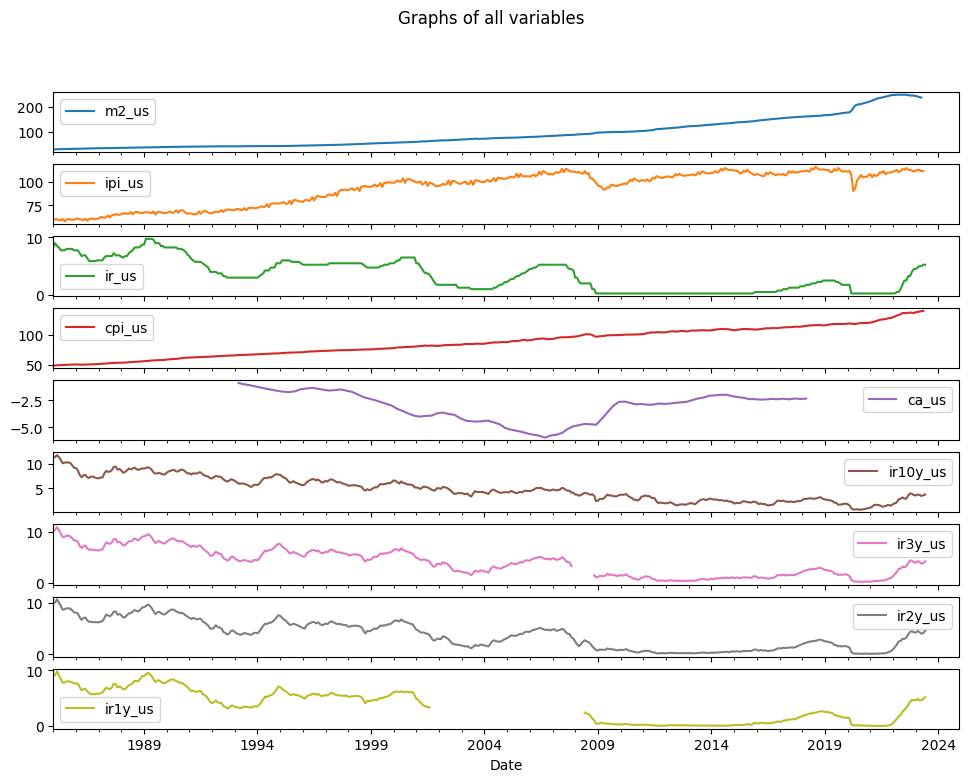

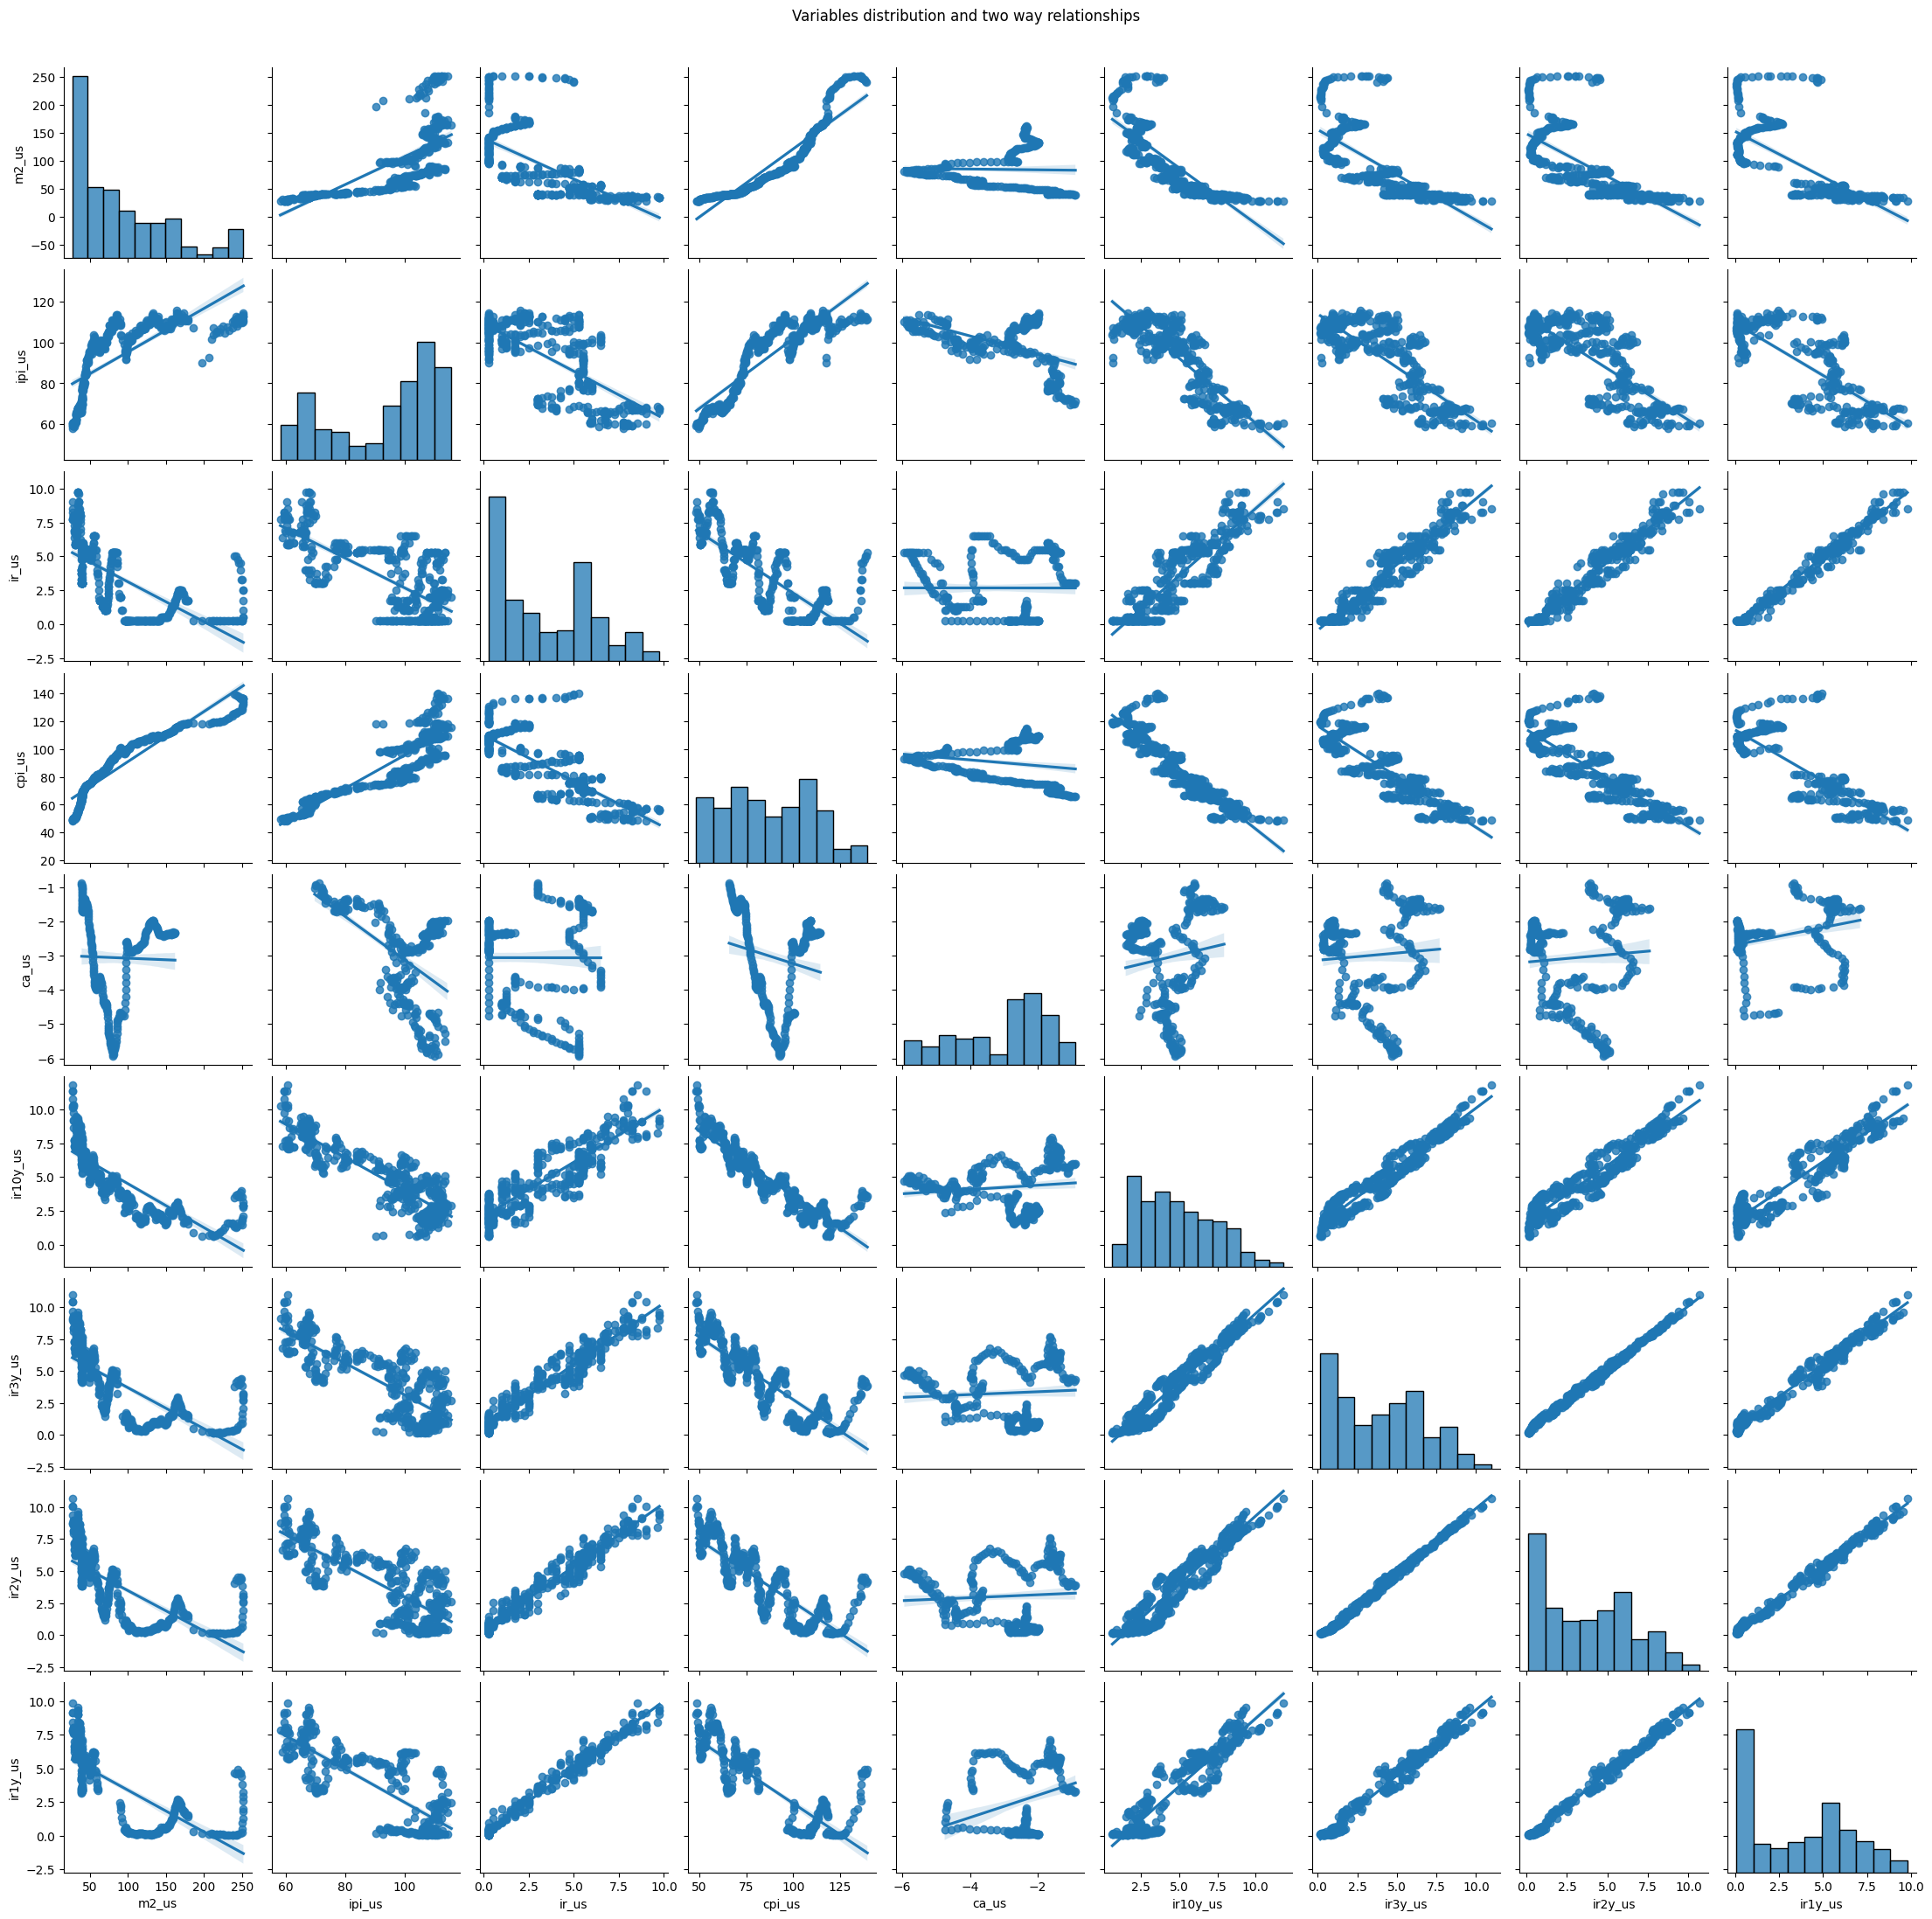

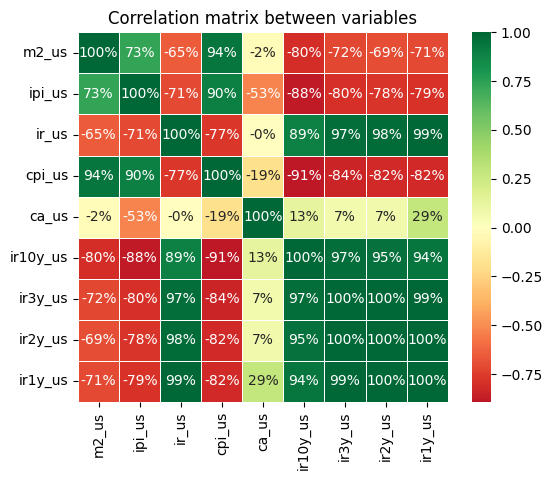

In [ ]:
#code to show exploratory data analysis

eda(data)

In [ ]:
#code to create specific dataframe for testing purposes to ensure no changes to original dataframe

vecm_df = pd.DataFrame(data[input('Please put the columns you want to use for this VECM model seperated by space: ').split(" ")].copy(deep = True)).loc[input('Please insert model sample start date in YYYY-MM-DD format '):input('Please insert model sample end date in YYYY-MM-DD format ')].dropna()

Please put the columns you want to use for this VECM model seperated by space: ir10y_us ipi_us m2_us cpi_us
Please insert model sample start date in YYYY-MM-DD format 1985-01
Please insert model sample end date in YYYY-MM-DD format 2023-06


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459 entries, 1985-02-28 to 2023-04-30
Freq: M
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ir10y_us  459 non-null    float64
 1   ipi_us    459 non-null    float64
 2   m2_us     459 non-null    float64
 3   cpi_us    459 non-null    float64
dtypes: float64(4)
memory usage: 17.9 KB
None




,ir10y_us,ipi_us,m2_us,cpi_us
Date,,,,
1985-02-28,11.405077,60.310981,27.290406,48.611477
1985-03-31,11.822000,60.386510,27.430678,48.794917
1985-04-30,11.402381,59.316562,27.537331,49.024216
1985-05-31,10.821636,59.277924,27.700788,49.207656
1985-06-30,10.142053,60.600652,27.968580,49.345236
1985-07-31,10.283182,58.047643,28.164497,49.436955
1985-08-31,10.319409,59.710575,28.332591,49.528675
1985-09-30,10.336400,60.572056,28.476341,49.666255
1985-10-31,10.207818,59.982018,28.610816,49.849694


,ir10y_us,ipi_us,m2_us,cpi_us
Date,,,,
2022-07-31,2.890895,112.508674,251.605929,135.871831
2022-08-31,2.893357,114.389568,251.098168,135.823678
2022-09-30,3.506209,112.811878,249.523878,136.115805
2022-10-31,3.968452,112.524063,248.456189,136.667958
2022-11-30,3.867545,111.781550,248.068992,136.529920
2022-12-31,3.618486,110.724590,247.598328,136.110761
2023-01-31,3.542864,111.910778,245.911588,137.199016
2023-02-28,3.745480,112.239850,244.338457,137.964876
2023-03-31,3.662957,112.684724,241.595621,138.421640




Data summary statistics


,ir10y_us,ipi_us,m2_us,cpi_us
count,459.000000,459.000000,459.000000,459.000000
mean,4.820607,93.300350,90.735899,87.445807
std,2.442972,17.629477,60.220324,23.141833
min,0.616700,58.047643,27.290406,48.611477
25%,2.702287,76.291382,40.415096,68.422947
50%,4.545522,100.007977,71.296345,85.941423
75%,6.594322,108.116845,126.353618,107.115390
max,11.822000,115.784659,251.605929,139.121921


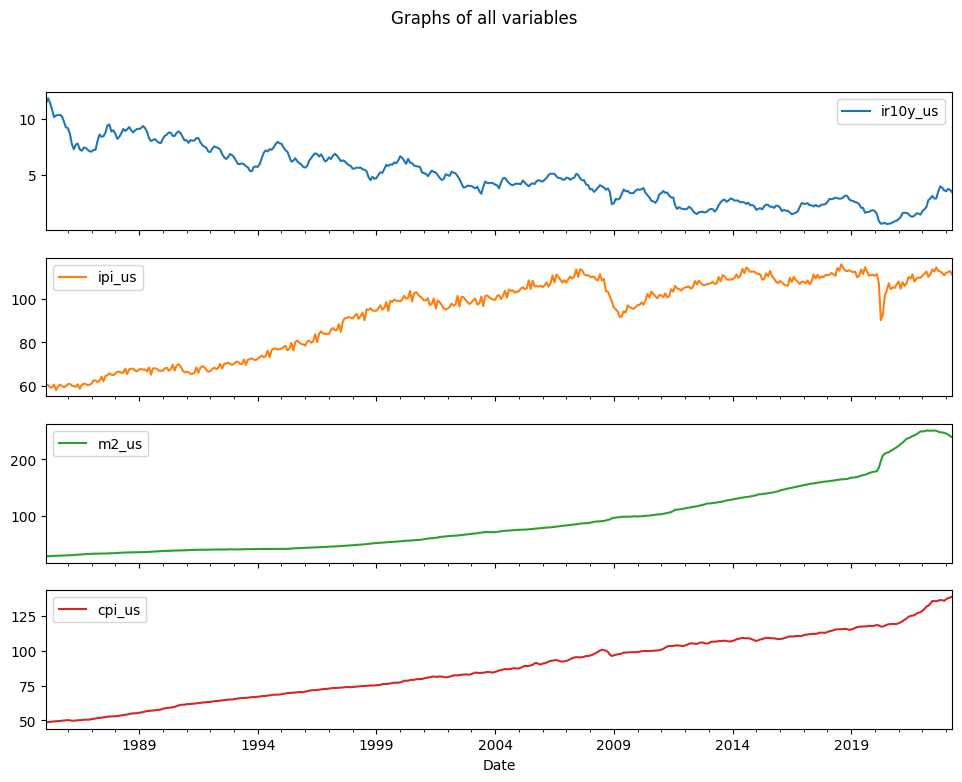

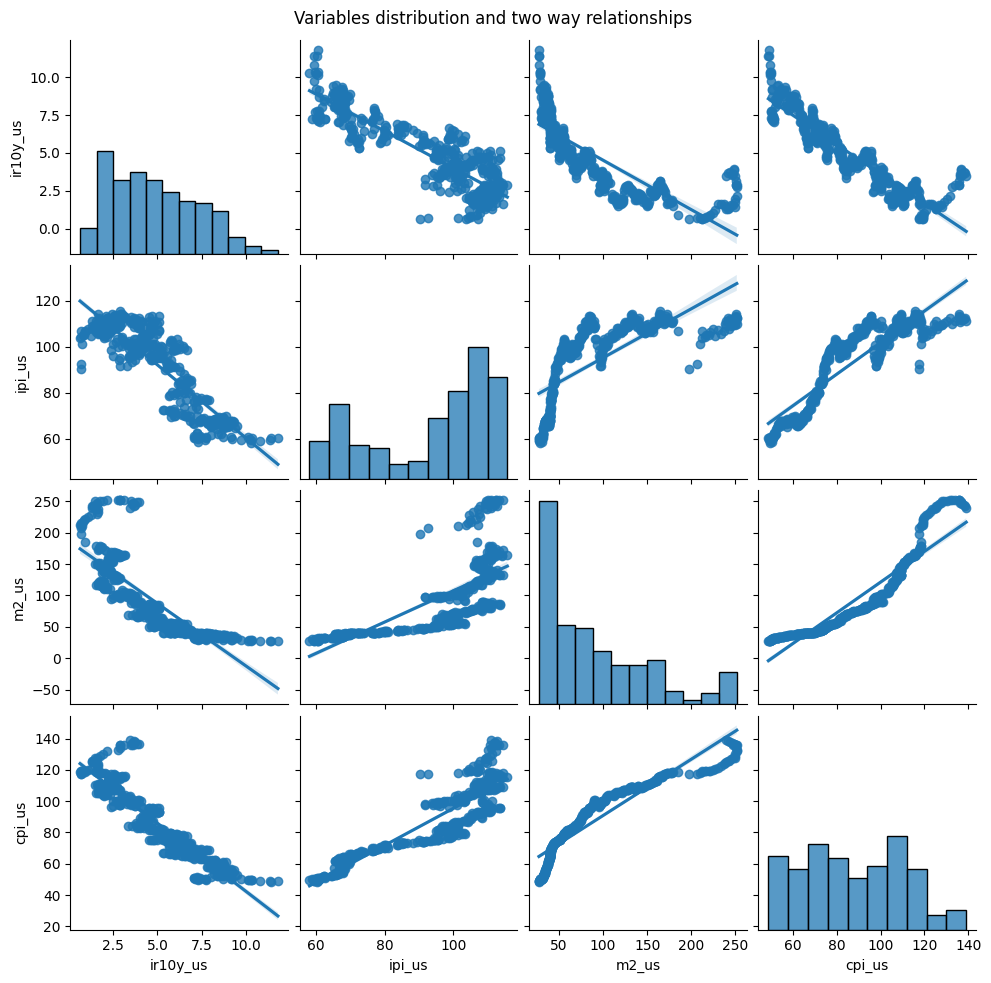

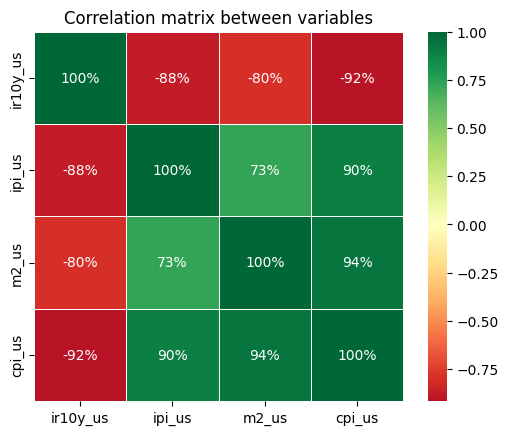

In [ ]:
#code for EDA

eda(vecm_df)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.008945,0.008945,0.008945
1,ipi_us,0.608439,0.608439,0.608439
2,m2_us,0.316177,0.316177,0.316177
3,cpi_us,0.638477,0.638477,0.638477



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.081499,0.081499,0.081499
1,ipi_us,0.491263,0.491263,0.491263
2,m2_us,1.000000,1.000000,1.000000
3,cpi_us,0.998555,0.998555,0.998555



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,ir10y_us,0.010000,0.010000,0.010000
1,ipi_us,0.010000,0.010000,0.010000
2,m2_us,0.010000,0.010000,0.010000
3,cpi_us,0.072553,0.072553,0.072553


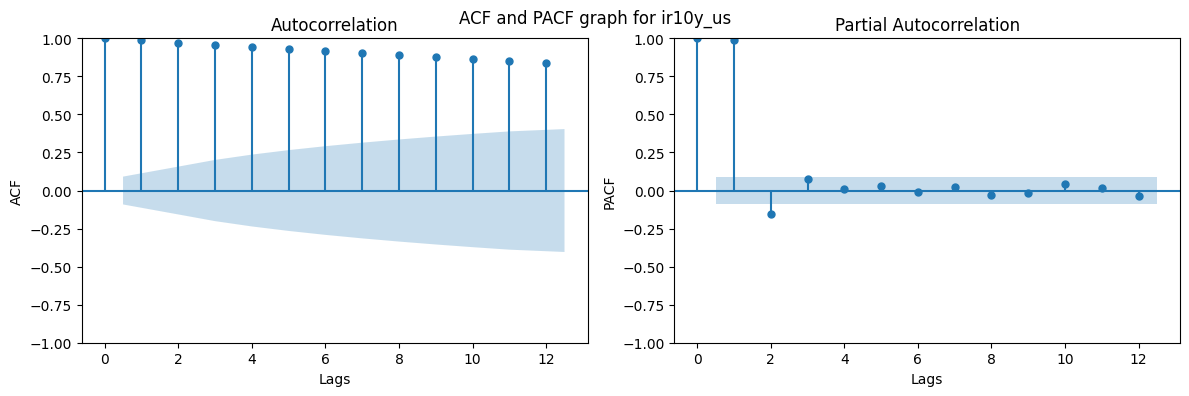

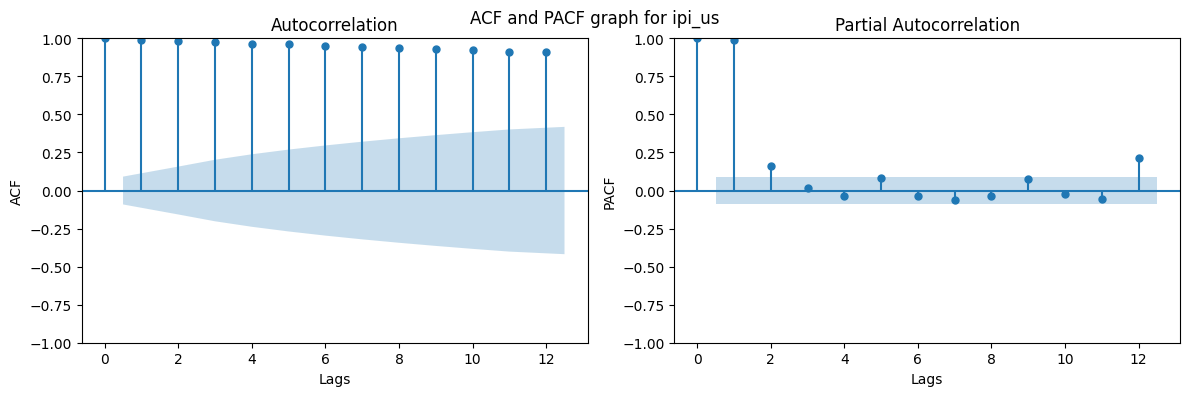

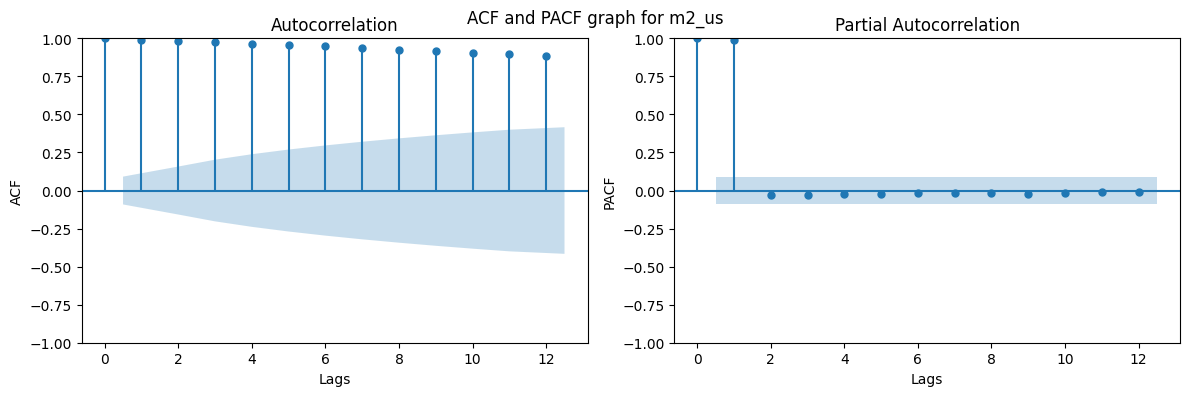

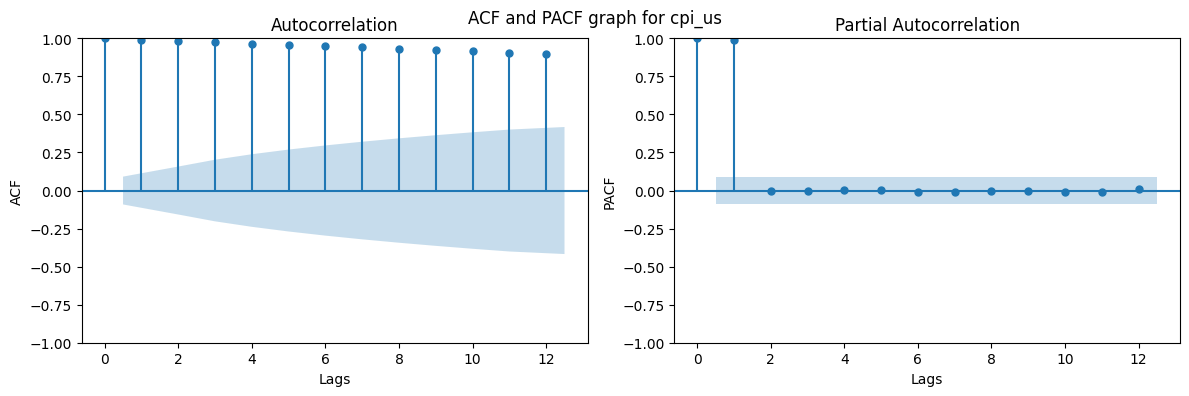

In [ ]:
# code to do stationary test

stationarity_test(vecm_df)
print()
print()
acf_pacf_graph(vecm_df)

In [ ]:
# code to search for optimal lag

vecm_optimal_lag(vecm_df)

n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): coli


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.689      -5.027    0.003382      -5.428
1       -6.738      -5.929    0.001185      -6.419
2       -6.901     -5.945*    0.001008     -6.524*
3       -6.912      -5.809   0.0009964      -6.477
4       -6.957      -5.706   0.0009533      -6.464
5       -6.968      -5.570   0.0009435      -6.417
6       -6.950      -5.406   0.0009604      -6.341
7       -6.962      -5.271   0.0009497      -6.295
8       -6.948      -5.110   0.0009639      -6.223
9       -6.911      -4.925    0.001002      -6.128
10     

12

In [ ]:
# code to do cointegration test

cointegration_test(vecm_df)

Insert optimal lag number obtained from test: 12
-1 - no deterministic terms, 0 - constant term, 1 - linear trend 1


Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          65.25          55.25
  1   4          29.89          35.01
-------------------------------------
Trace method cointegration test suggest a cointegration rank of 1


Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          35.36          30.82
  1   2          17.24          24.25
-------------------------------------
Maximum Eigenvalue method cointegration test suggest a cointegration rank of 1


1

In [ ]:
# code to transform data, dropna is optional

vecm_df_transformed = transform_data(vecm_df).dropna()

1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459 entries, 1985-02-28 to 2023-04-30
Freq: M
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ir10y_us  459 non-null    float64
 1   ipi_us    459 non-null    float64
 2   m2_us     459 non-null    float64
 3   cpi_us    459 non-null    float64
dtypes: float64(4)
memory usage: 17.9 KB
None




,ir10y_us,ipi_us,m2_us,cpi_us
Date,,,,
1985-02-28,11.405077,60.310981,27.290406,48.611477
1985-03-31,11.822000,60.386510,27.430678,48.794917
1985-04-30,11.402381,59.316562,27.537331,49.024216
1985-05-31,10.821636,59.277924,27.700788,49.207656
1985-06-30,10.142053,60.600652,27.968580,49.345236
1985-07-31,10.283182,58.047643,28.164497,49.436955
1985-08-31,10.319409,59.710575,28.332591,49.528675
1985-09-30,10.336400,60.572056,28.476341,49.666255
1985-10-31,10.207818,59.982018,28.610816,49.849694


,ir10y_us,ipi_us,m2_us,cpi_us
Date,,,,
2022-07-31,2.890895,112.508674,251.605929,135.871831
2022-08-31,2.893357,114.389568,251.098168,135.823678
2022-09-30,3.506209,112.811878,249.523878,136.115805
2022-10-31,3.968452,112.524063,248.456189,136.667958
2022-11-30,3.867545,111.781550,248.068992,136.529920
2022-12-31,3.618486,110.724590,247.598328,136.110761
2023-01-31,3.542864,111.910778,245.911588,137.199016
2023-02-28,3.745480,112.239850,244.338457,137.964876
2023-03-31,3.662957,112.684724,241.595621,138.421640




Data summary statistics


,ir10y_us,ipi_us,m2_us,cpi_us
count,459.000000,459.000000,459.000000,459.000000
mean,4.820607,93.300350,90.735899,87.445807
std,2.442972,17.629477,60.220324,23.141833
min,0.616700,58.047643,27.290406,48.611477
25%,2.702287,76.291382,40.415096,68.422947
50%,4.545522,100.007977,71.296345,85.941423
75%,6.594322,108.116845,126.353618,107.115390
max,11.822000,115.784659,251.605929,139.121921


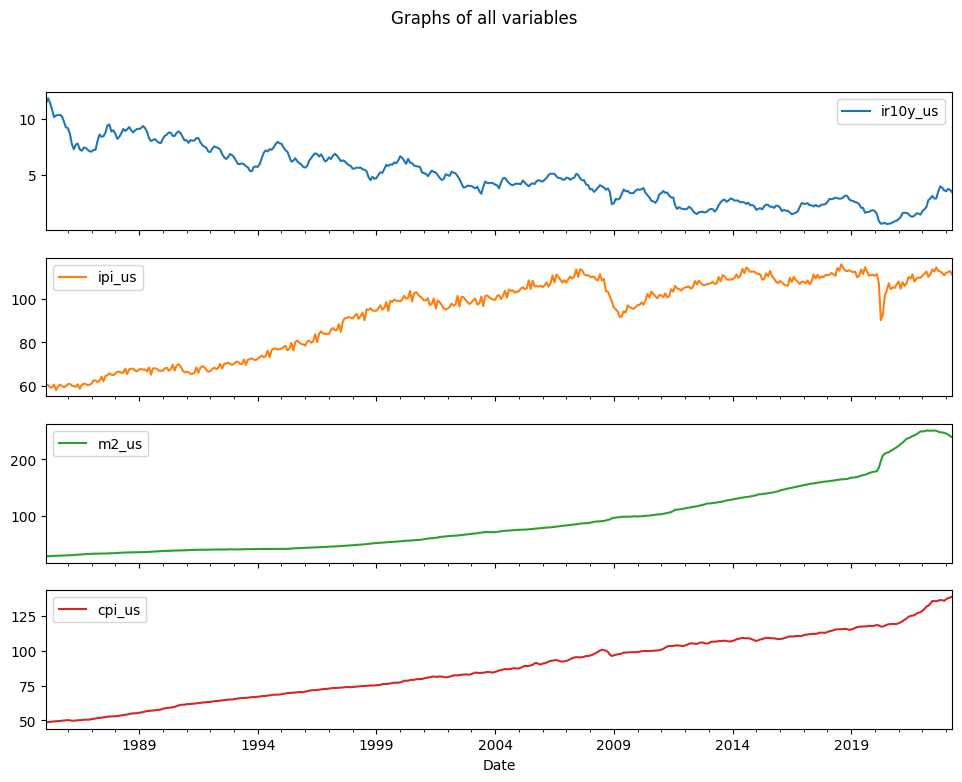

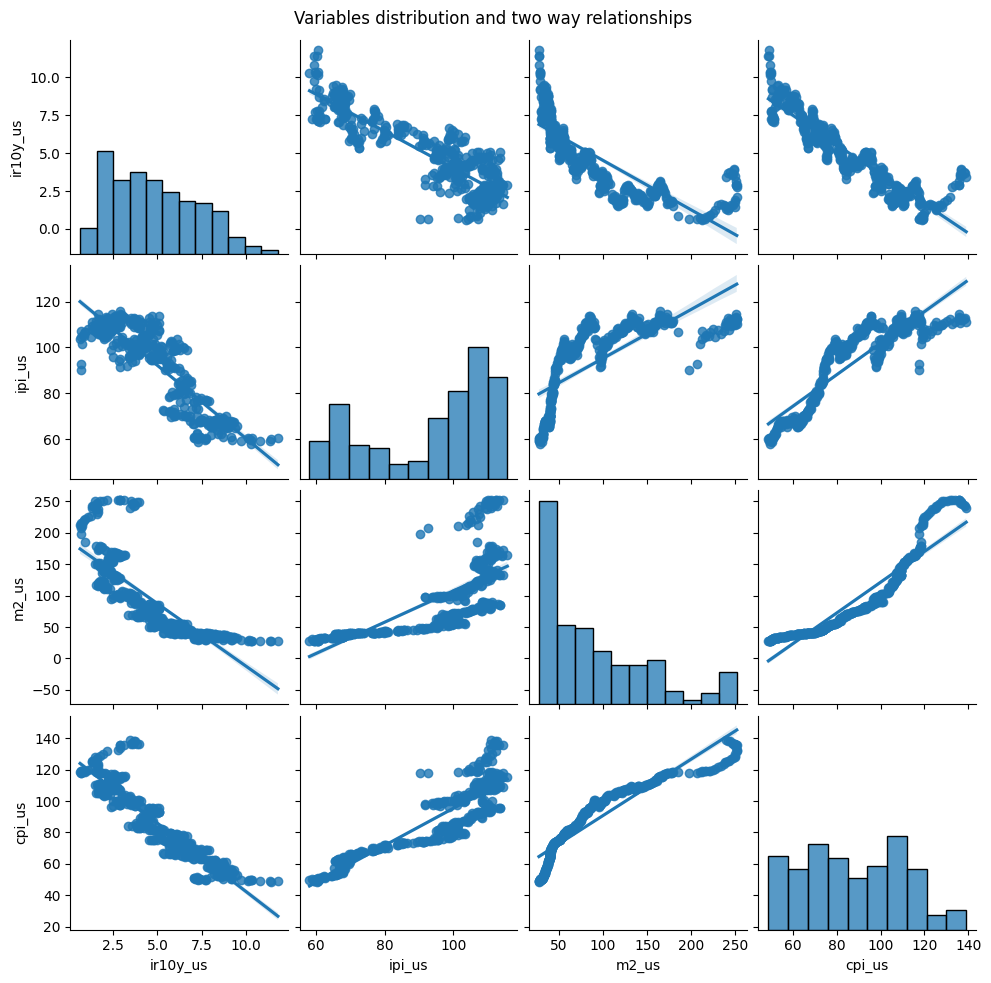

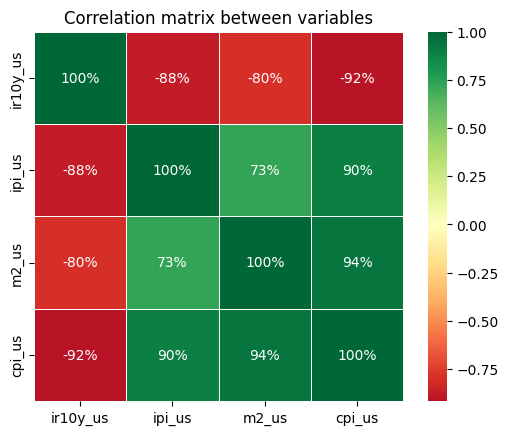

In [ ]:
#code for eda

eda(vecm_df_transformed)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.008945,0.008945,0.008945
1,ipi_us,0.608439,0.608439,0.608439
2,m2_us,0.316177,0.316177,0.316177
3,cpi_us,0.638477,0.638477,0.638477



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,ir10y_us,0.081499,0.081499,0.081499
1,ipi_us,0.491263,0.491263,0.491263
2,m2_us,1.000000,1.000000,1.000000
3,cpi_us,0.998555,0.998555,0.998555



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-8-4116c1d7d5b7>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,ir10y_us,0.010000,0.010000,0.010000
1,ipi_us,0.010000,0.010000,0.010000
2,m2_us,0.010000,0.010000,0.010000
3,cpi_us,0.072553,0.072553,0.072553


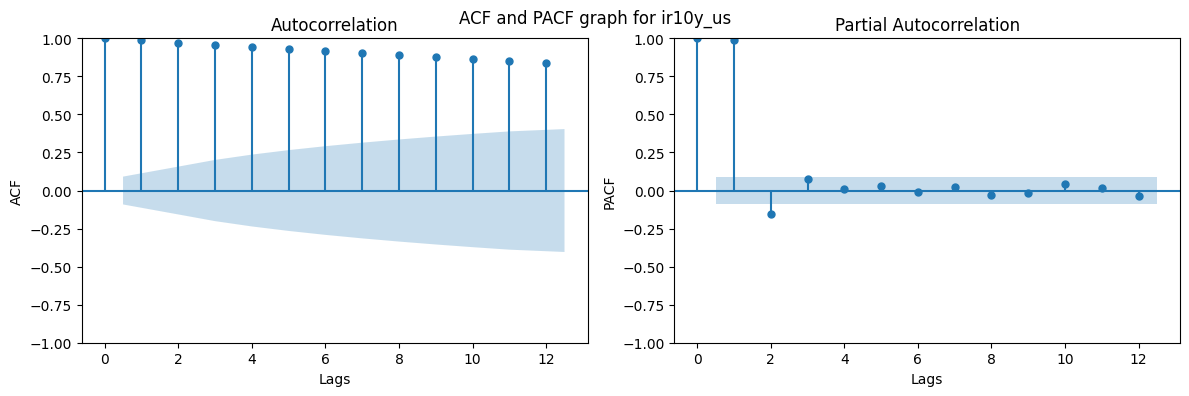

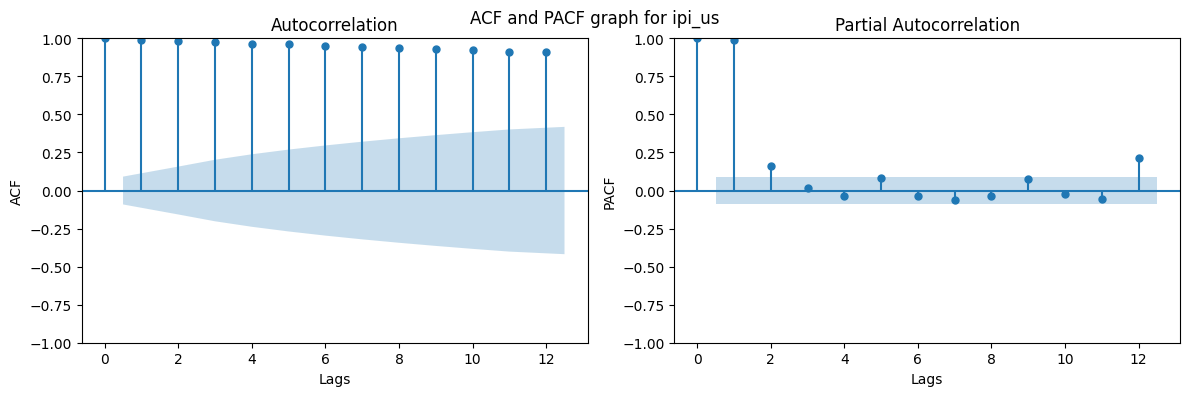

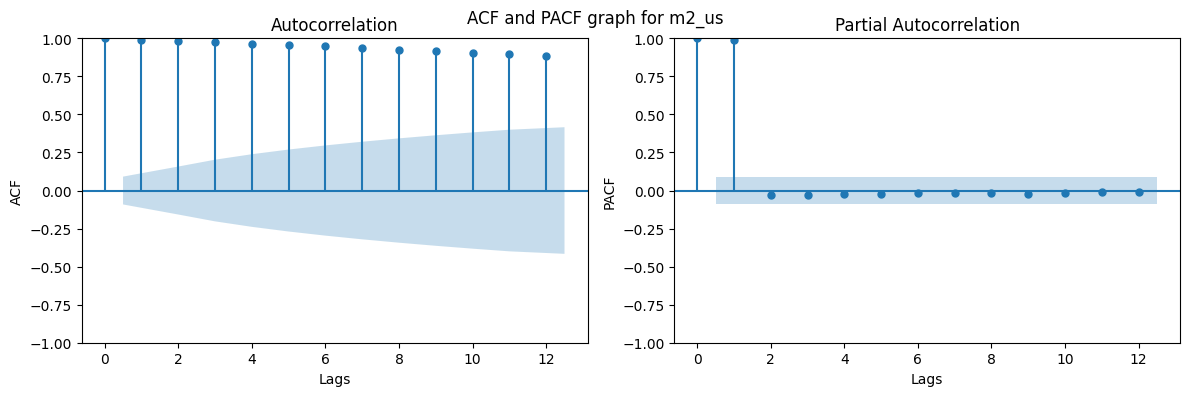

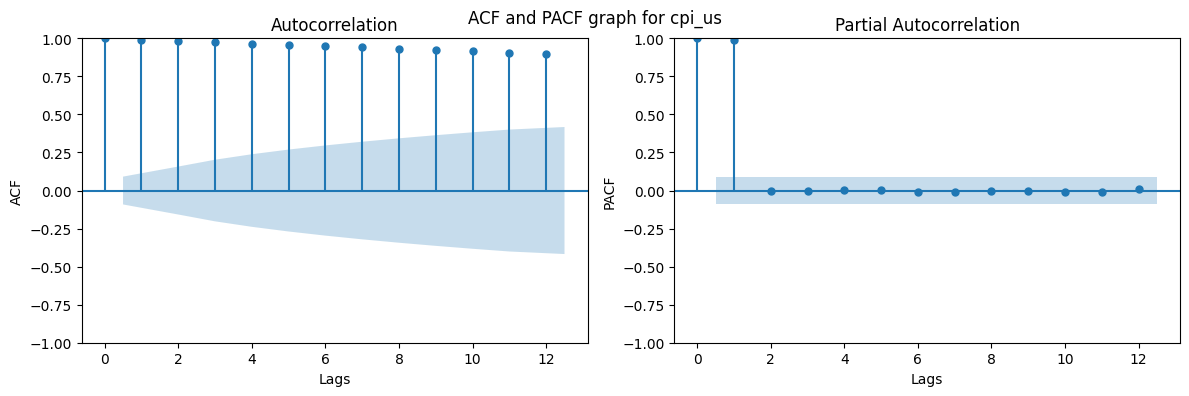

In [ ]:
# code to do stationary test

stationarity_test(vecm_df_transformed)
print()
print()
acf_pacf_graph(vecm_df_transformed)

In [ ]:
# code to do cointegration test

cointegration_test(vecm_df_transformed)

Insert optimal lag number obtained from test: 2
-1 - no deterministic terms, 0 - constant term, 1 - linear trend 1


Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          84.85          55.25
  1   4          41.68          35.01
  2   4          17.32          18.40
-------------------------------------
Trace method cointegration test suggest a cointegration rank of 2


Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          43.17          30.82
  1   2          24.36          24.25
  2   3          16.08          17.15
-------------------------------------
Maximum Eigenvalue method cointegration test suggest a cointegration rank of 2


2

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us,cpi_us,m2_us,ipi_us
Please enter the name of your main endogenous variables: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1985-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: cpi_us m2_us ipi_us
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be diff separated by space: cpi_us m2_us ipi_us
1 if need second difference, 0 if do not need second difference: 0
Column: cpi_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Column: m2_us
Please enter the number of first difference i.e. 1 for d

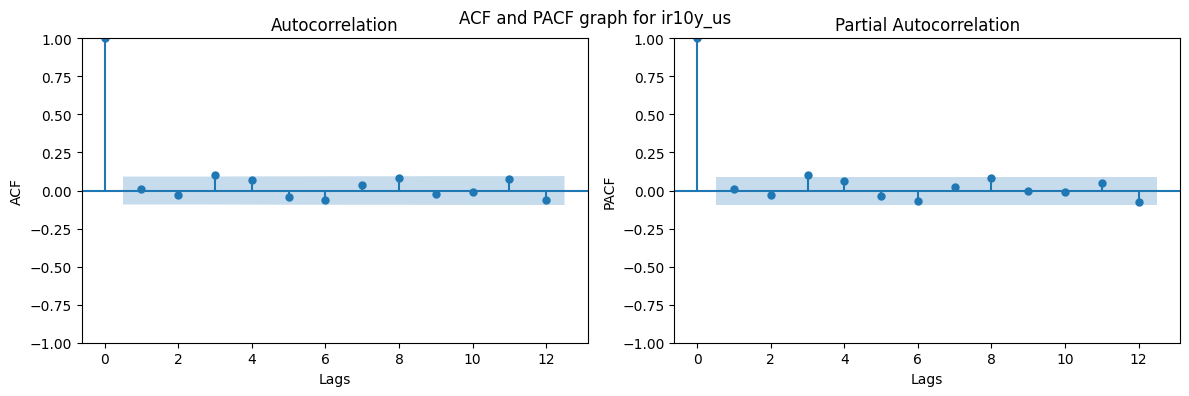

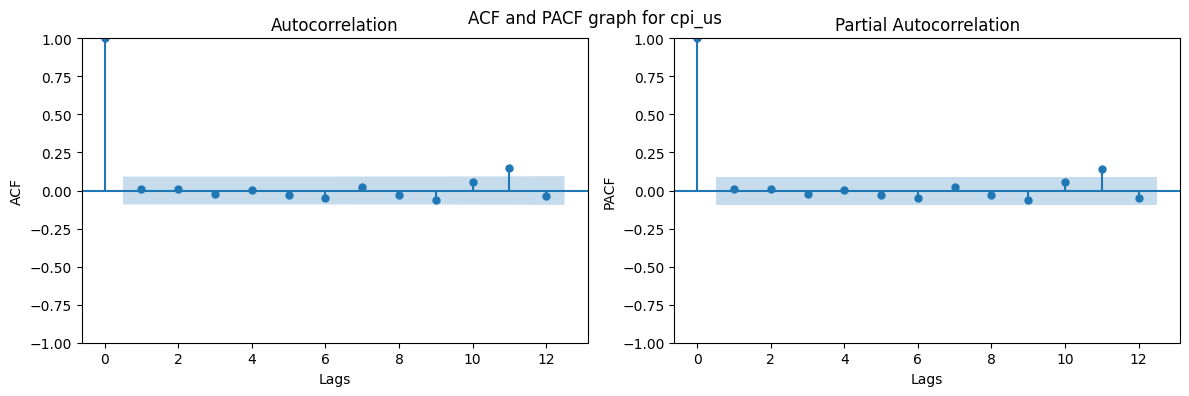

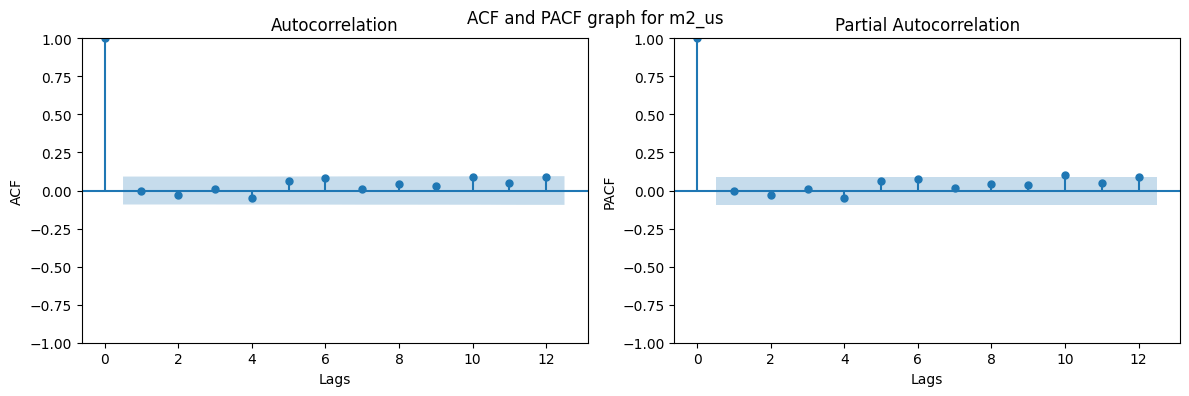

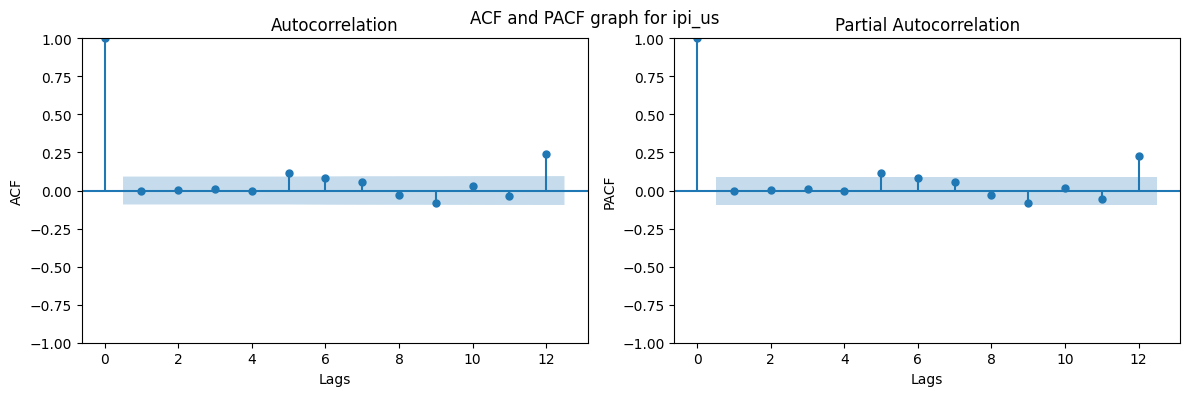




Instantaneous causality Wald-test. H_0: ['cpi_us', 'm2_us', 'ipi_us'] do not instantaneously cause ir10y_us. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         27.03          7.815   0.000  3
----------------------------------------


Granger causality F-test. H_0: cpi_us does not Granger-cause ir10y_us. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         6.221          2.610   0.000 (3, 1700)
-----------------------------------------------


Granger causality F-test. H_0: m2_us does not Granger-cause ir10y_us. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1017          2.610   0.959 (3, 1700)
-----------------------------------------------


Granger causality F-test. H_0: ipi_us 

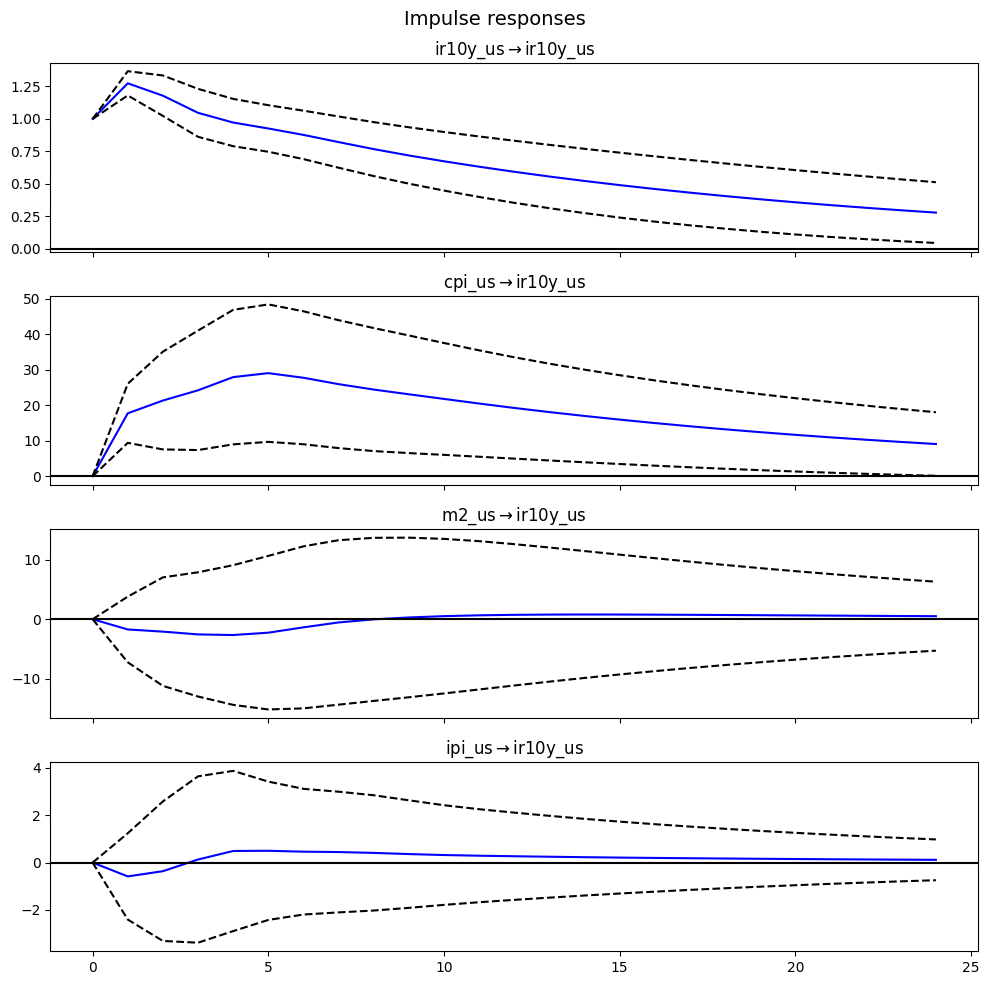





Enter the Y label name and unit ir10y_us


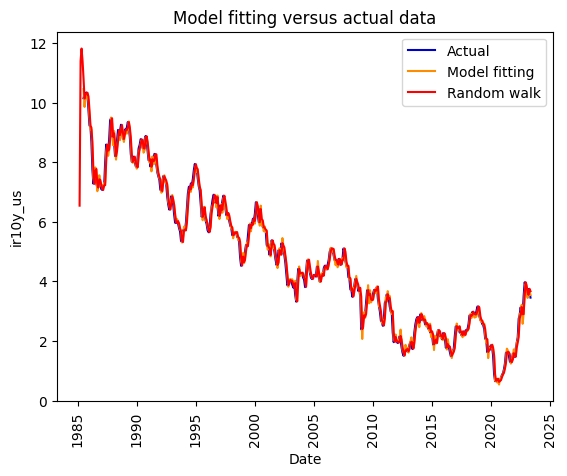



Please put model name: vecm_1
Please put dependent variable name: ir10y_us
Forecast Accuracy of: vecm_1  used to forecast  ir10y_us
mape   :  0.0445
me     :  -0.0
mae    :  0.1648
mpe    :  0.0032
rmse   :  0.2111
corr   :  0.996
minmax :  0.0421


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0486
me     :  0.0106
mae    :  0.1923
mpe    :  0.0063
rmse   :  0.3292
corr   :  0.9909
minmax :  0.0456


In [ ]:
# code to run VECM model (vecm_1)

model, fit, predict, residual, actual = vecm_model(data)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: cpi_us m2_us ipi_us
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be diff separated by space: cpi_us m2_us ipi_us
1 if need second difference, 0 if do not need second difference: 0
Column: cpi_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Column: m2_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Column: ipi_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Please en

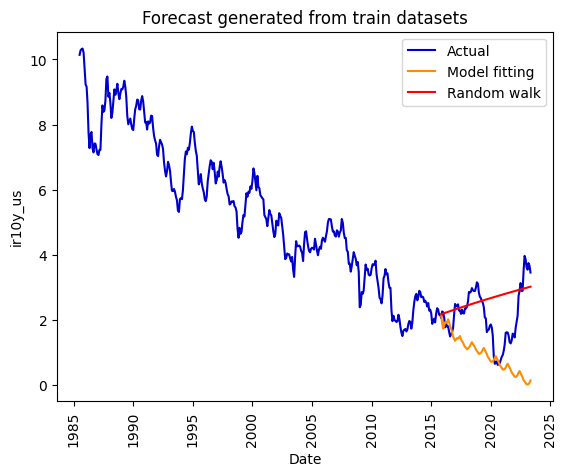



Please put model name: vecm_2
Please put dependent variable name: ir10y_us
Forecast Accuracy of: vecm_2  used to forecast  ir10y_us
mape   :  0.5231
me     :  -1.2056
mae    :  1.2513
mpe    :  -0.482
rmse   :  1.5891
corr   :  -0.1232
minmax :  0.5198


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.584
me     :  0.4752
mae    :  0.7234
mpe    :  0.507
rmse   :  0.957
corr   :  0.0882
minmax :  0.2605
RMSE for the Second Quarter (VECM Model Fitting): 0.36242734072721783
RMSE for the Third Quarter (VECM Model Fitting): 0.50790741607882
RMSE for the Fourth Quarter (VECM Model Fitting): 0.2609631183056518
RMSE for Four Quarters Ahead (VECM Model Fitting): 0.3415555901803783
RMSE for Four Quarters Ahead (Random Walk): 0.09474465780612935


In [ ]:
vecm_simple_validation(actual) #vecm_1

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us,ir_us
Please enter the name of your main endogenous variables: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1985-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'ir_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1

Model parameter setting and fitting
Select your deterministic terms: n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - li

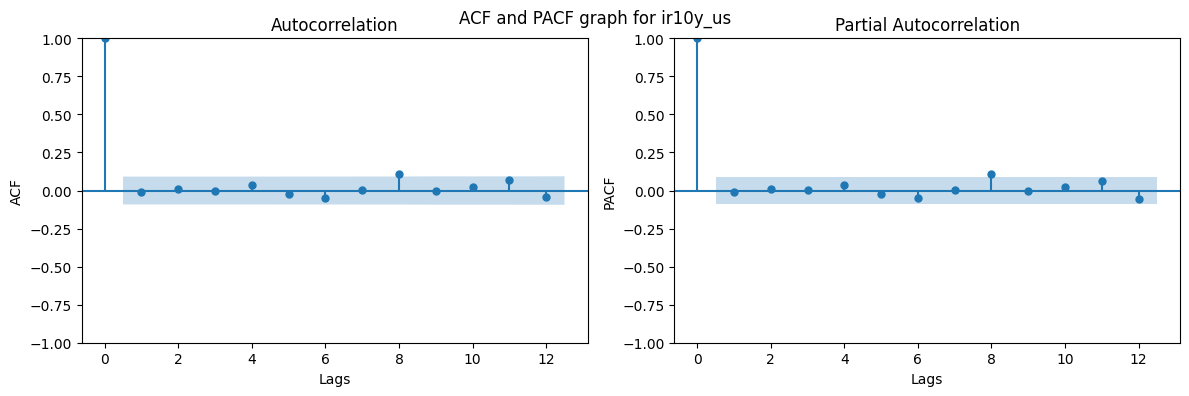

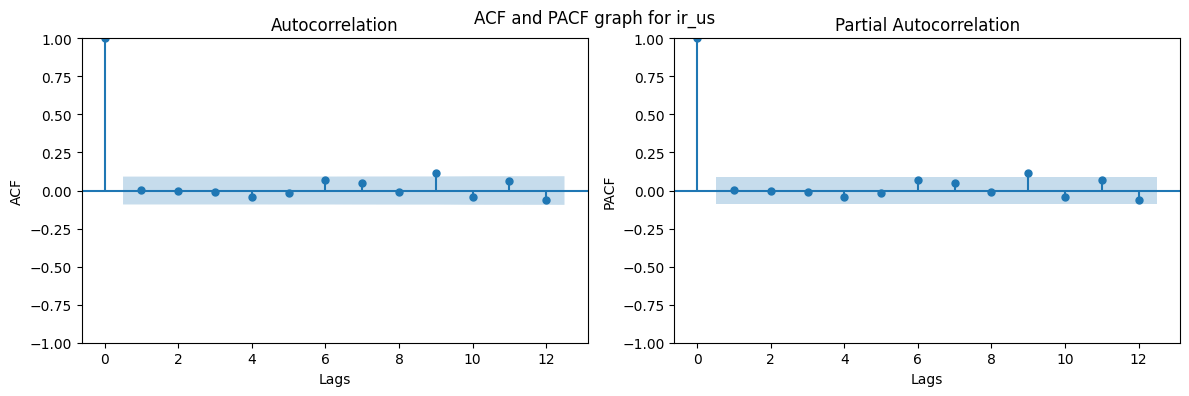




Instantaneous causality Wald-test. H_0: ir_us does not instantaneously cause ir10y_us. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         41.93          3.841   0.000  1
----------------------------------------


Granger causality F-test. H_0: ir_us does not Granger-cause ir10y_us. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.4423          2.382   0.778 (4, 866)
----------------------------------------------


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ir_us does not Granger-cause ir10y_us: fail to reject at 5% significance level. Test statistic: 0.442, critical value: 2.382>, p-value: 0.778>





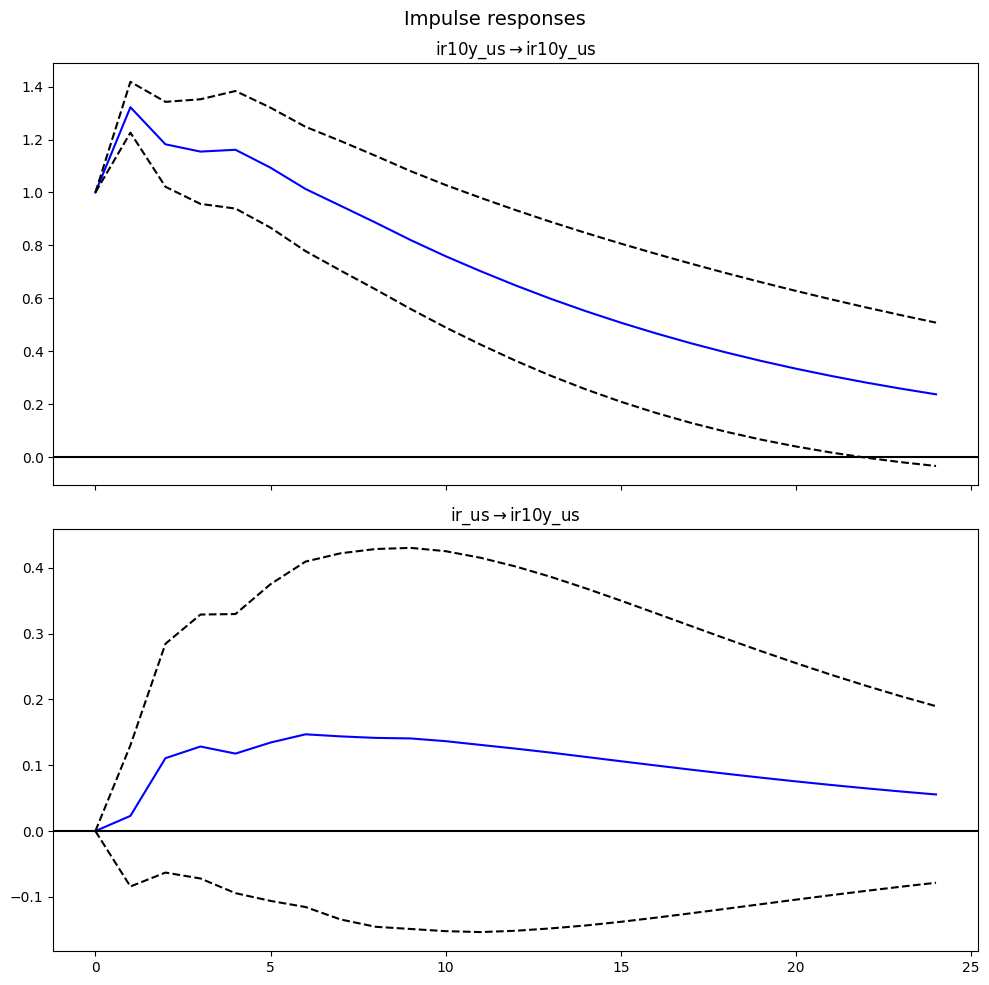





Enter the Y label name and unit ir10y_us


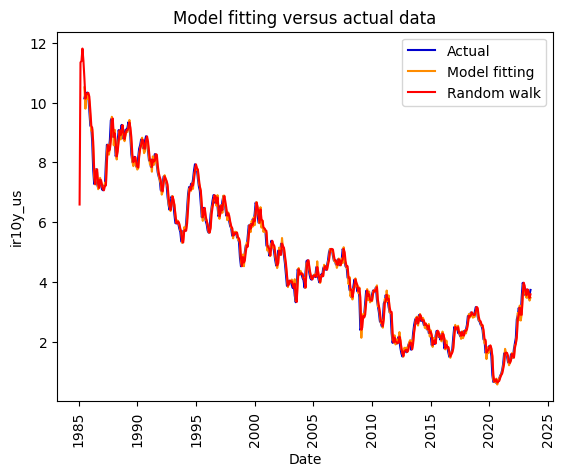



Please put model name: vec_2
Please put dependent variable name: ir10y_us
Forecast Accuracy of: vec_2  used to forecast  ir10y_us
mape   :  0.0453
me     :  0.0
mae    :  0.1666
mpe    :  0.0035
rmse   :  0.2134
corr   :  0.9959
minmax :  0.0427


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0484
me     :  0.0103
mae    :  0.1916
mpe    :  0.0062
rmse   :  0.3251
corr   :  0.9912
minmax :  0.0454


In [ ]:
# code to run VECM model (vecm_2)

model, fit, predict, residual, actual = vecm_model(data)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'ir_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Please enter the name of your main endogenous variables: ir10y_us

Model parameter setting and fitting
Select your deterministic terms: n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept) co

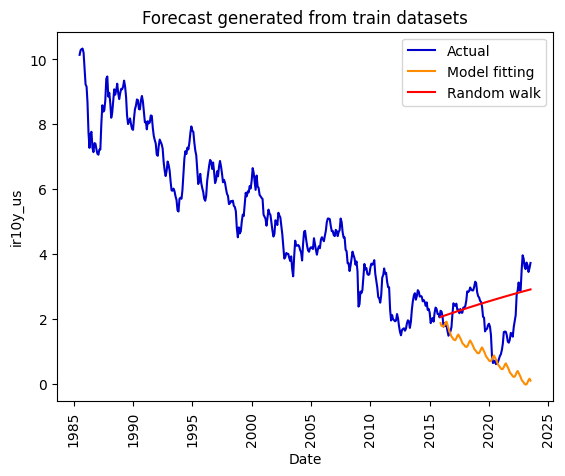



Please put model name: vecm
Please put dependent variable name: ir10y_us
Forecast Accuracy of: vecm  used to forecast  ir10y_us
mape   :  0.536
me     :  -1.2793
mae    :  1.3097
mpe    :  -0.5038
rmse   :  1.6673
corr   :  -0.1664
minmax :  0.5333


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.5461
me     :  0.3373
mae    :  0.7035
mpe    :  0.4303
rmse   :  0.9058
corr   :  0.1462
minmax :  0.2584
RMSE for the Second Quarter (VECM Model Fitting): 0.4397004280649037
RMSE for the Third Quarter (VECM Model Fitting): 0.2913103932586223
RMSE for the Fourth Quarter (VECM Model Fitting): 0.00038717707472946117
RMSE for Four Quarters Ahead (VECM Model Fitting): 0.32489499799653565
RMSE for Four Quarters Ahead (Random Walk): 0.20604829578513573


In [ ]:
vecm_simple_validation(actual) #vecm_2

In [ ]:
# Create a dictionary to store the accuracy results
accuracy_results_dict = {
    'Model': ['vecm', 'vecm with random walk'],
    'Dependent_Variable': ['ir10y_us', 'ir10y_us'],
    'mape': [1.0007, 0.0508],
    'me': [-4.1008, 0.0078],
    'mae': [4.1008, 0.1754],
    'mpe': [-1.0007, 0.0068],
    'rmse': [4.513, 0.268],
    'corr': [-0.0325, 0.9911],
    'minmax': [1.0007, 0.0474]
}

# Create a DataFrame from the dictionary
accuracy_df = pd.DataFrame(accuracy_results_dict)

# Save the DataFrame to an Excel file
accuracy_df.to_excel('vecmaccuracy_results.xlsx', index=False)

# Display the DataFrame
display(accuracy_df)

,Model,Dependent_Variable,mape,me,mae,mpe,rmse,corr,minmax
0,vecm,ir10y_us,1.0007,-4.1008,4.1008,-1.0007,4.513,-0.0325,1.0007
1,vecm with random walk,ir10y_us,0.0508,0.0078,0.1754,0.0068,0.268,0.9911,0.0474
